# Bin cross-slope transects of along-slope velocity into depth space

This script interpolates 3d ocean data into an ASC coordinate system. The actual calculation is done for segments of the coastline which are combined into one file at the end. You can eiter use daily or monhtly data.

This script develops the code to bin the cross-slope transects into depth bins and shows the steps and decisions made on the way. 

Things to note:
- Am of the ASC coordinate system is to focus on the ragional and spatial variability of quantities along the Antarctic continental slope which is usually shown in an akward projection due to the long, but narrow geometry.
- The ocean data (e.g. along-slope velocity) is interpolated onto a selection of cross-slope transects. The information on the orientation of the cross-slope transects, that is the lat and lon locations, are calculated in `Select_transects_630m_2000m.ipynb`.
- Afterwards the interpolated cross-slope transects are binned into depth intervals which are given by the model's vertical resolution. E.g. all velocity at approximately 500 m depth is averaged (lateral) into a single bin (depth information is kept). This allows to compare two transects of which one might have a shallow slope covering e.g. 10 grid cells (on cross-slope direction) and the second transect is steep and thus has only 1 grid cell at a given bathymetry.  
- A problem occurs when binning: Mainly, the interpolation function that I use assumes a monotonic increase in the bathymetry. However, not all cross-slope transects fulfill this recquirement. Some show 'bumps', meaning they go shallower and deeper again.  
    - Each transect is checked for a monotonic increase. If this is the case, the interpolation is simple.
    - There are two options to check for the bathymetry:
        - (i) Interpolate hu to the cross-slope transect. The advantage is the finer resolution, meaning we don't have a step function and can easily find local minima and maxima. However, this does not necessarily correspond to the exact location of the stpes in the velocity field.
        - (ii) Find the maximum depth of each water column of the respective cross-slope transect. The disadvantage is that it is harder to find local minima or maxima. But in the end this is the quantity that we want to use for the interpolation in the binning process.
    - If there is not a monotonic increase, there are two main cases:
        - (i) The non-monotonic part is near the head/tail of the transect
            - In this case, I cut the transect short. This leads to a varying length of each transect. But that is okay as we are going to bin them anyway.
        - (ii) There are bumps in the middle of the transect. In this case, I divide the transects into small (<200 m at the moment) and big (>200 m at the moment) bumps.
            - Small bumps: are flattened, this may introduce some nans to the binned product
            - Big bumps: mostly ignored or cut short
- The binning itself is done using the xarray interp() function with the flag method='nearest'. This allows us to retain most information near the bottom. Nevertheless, there will be some nan grid cells near the bottom.

The following script guides through all the different steps and helps to justify the different choices taken on the way.

### First, load in python modules

In [1]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client

# Optional modules
import cmocean as cm
import xarray.ufuncs as xu
import matplotlib.path as mpath
import cartopy.crs as ccrs
import xgcm
import matplotlib.colors as colors
from scipy.interpolate import griddata

# For metpy function
# (use the conda3 unstable kernel)
from metpy.interpolate import cross_section
#from metpy.interpolate import interpolate_to_slice

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores

In [2]:
client = Client() # n_workers=4
client

Client Scheduler: tcp://127.0.0.1:33759 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


Nominate a database from wich to load the data and define an experiment

In [3]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

### Load data

In [4]:
lat_slice = slice(-80, -58)

start_time = '2086-01-01'
end_time   = '2086-01-02'#'2086-12-31'

Load transect information calculated in `Calc_continental_slope_transects.ipynb`

In [5]:
out_path = '/g/data/x77/wgh581/Post_Process/'
#infile = out_path + 'Antarctic_slope_transects.npz'
infile = out_path + 'Antarctic_slope_transects_630m_2000m.npz'
data = np.load(infile)
lat_shelf = data['lat_630m']
lon_shelf = data['lon_630m']
lat_deep  = data['lat_2000m']
lon_deep  = data['lon_2000m']

Load bathymetry

In [6]:
# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)  
hu = hu.load()

# lat/lon information
xu_ocean = hu.xu_ocean.values
yu_ocean = hu.yu_ocean.values

Load velocity

In [8]:
# One day to test
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, ncfile="ocean_daily_3d_u_%.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice) 
v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, ncfile="ocean_daily_3d_v_%.nc")
v = v.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)
u = u[0,:,:,:]
v = v[0,:,:,:]

In [7]:
# Monthly climatology
start_time = '2080-01-01'
end_time   = '2089-12-31'
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)
v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
v = v.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)
# Monthly climatology
u = u.groupby('time.month').mean('time')
v = v.groupby('time.month').mean('time')

Along-slope velocity

In [8]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [9]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Calculate the magnitude of the topographic slope
slope = xu.sqrt(dhu_dx**2 + dhu_dy**2)

In [10]:
# Along-slope velocity
u_along = u*dhu_dy/slope - v*dhu_dx/slope
u_along = u_along.load()

Prepare data to interpolate to cross-section

In [11]:
# Create dataset
ds = xr.Dataset({"u_along": u_along, "lat": u_along.yu_ocean, "lon": u_along.xu_ocean, "hu": hu})
# Rename coordinate names
ds = ds.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds['x'] = ds['x']+100
ds['x'].attrs = u_along['xu_ocean'].attrs
# MetPy parsing
u_parsed = ds.metpy.parse_cf('u_along', coordinates={'y': 'y', 'x': 'x'})

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


In [8]:
ds_hu = xr.Dataset({"hu": hu})
ds_hu = ds_hu.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
ds_hu['x'] = ds_hu['x']+100
ds_hu['x'].attrs = hu['xu_ocean'].attrs
# Assgin CF-conforming grid mapping variable

#ds_hu = ds_hu.assign_attrs({'units':'m'})
hu_parsed  = ds_hu.metpy.parse_cf('hu', coordinates={'y': 'y', 'x': 'x'})

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


In [30]:
ds_hu.hu

<xarray.DataArray 'hu' (y: 503, x: 3600)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [1678.9584, 1639.3334, 1639.3334, ..., 1592.9722, 1643.5834,
        1646.8873],
       [1646.8873, 1639.3334, 1639.3334, ..., 1573.4584, 1643.5834,
        1646.8873],
       [1619.2024, 1640.2916, 1640.2916, ..., 1573.4584, 1642.4048,
        1619.2024]], dtype=float32)
Coordinates:
  * x         (x) float64 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * y         (y) float64 -79.99 -79.95 -79.9 -79.86 ... -58.12 -58.07 -58.02
    geolon_c  (y, x) float32 nan nan nan nan nan ... 79.6 79.7 79.8 79.9 80.0
    geolat_c  (y, x) float32 nan nan nan ... -58.015026 -58.015026 -58.015026
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point

In [24]:
hu_parsed

<xarray.DataArray 'hu' (y: 503, x: 3600)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [1678.9584, 1639.3334, 1639.3334, ..., 1592.9722, 1643.5834,
        1646.8873],
       [1646.8873, 1639.3334, 1639.3334, ..., 1573.4584, 1643.5834,
        1646.8873],
       [1619.2024, 1640.2916, 1640.2916, ..., 1573.4584, 1642.4048,
        1619.2024]], dtype=float32)
Coordinates:
  * x         (x) float64 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * y         (y) float64 -79.99 -79.95 -79.9 -79.86 ... -58.12 -58.07 -58.02
    geolon_c  (y, x) float32 nan nan nan nan nan ... 79.6 79.7 79.8 79.9 80.0
    geolat_c  (y, x) float32 nan nan nan ... -58.015026 -58.015026 -58.015026
    crs       object Projection: latitude_longitude
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point

## 1 - Interpolation of model grid onto transects: linear interpolation vs nearest value

In [19]:
# Function to interpolate model grid to transect
def get_transect(ii, method='linear'):
    """
    ii: number of transect
    method of interpolation:
    method = 'linear'
    method = 'nearest'
    """
    
    max_depth = 2010 # (st_ocean nearest value to 2000 m)
    min_depth = 620  # (st_ocean nearest value to 650 m)

    step_no = 50

    section_raw = cross_section(u_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type=method)
    hu_raw      = cross_section(hu_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type=method)
    
    # Get array with maximum water column depth from cross-slope transect's st_ocean
    depth_array = section_raw * 0 + section_raw.st_ocean
    depth_array = depth_array.max(dim='st_ocean', skipna=True)#[0,:]  # (skipping nans)
    
    # Finished
    return section_raw, hu_raw, depth_array

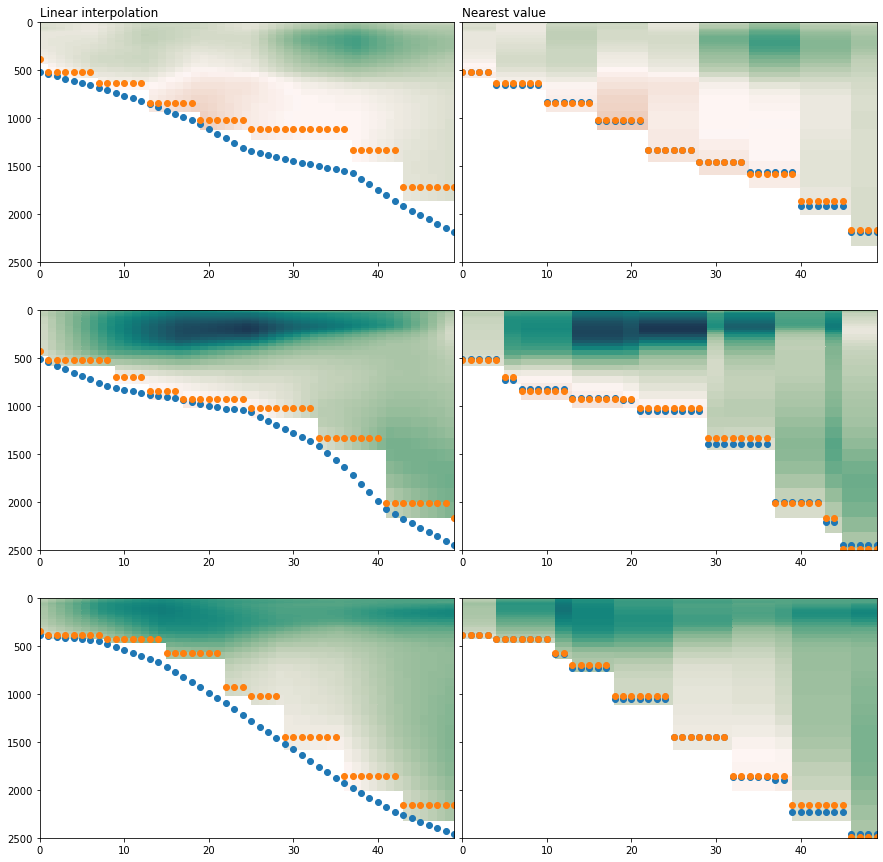

In [15]:
vmin_val = -0.2
vmax_val = 0.2

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15,15))

gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 0.05], hspace=0.2)#, wspace=1.5)

for ii in range(3):
    
    gs_tmp = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[ii,:2], wspace=0.02)
    
    # linear interpolation
    section_tmp, hu_tmp, depth_array_tmp = get_transect(ii*10, 'linear')
    ax = fig.add_subplot(gs_tmp[0])
    if ii == 0:
        plt.title('Linear interpolation', loc='left')
    plt.pcolormesh(section_tmp.index, section_tmp.st_ocean, section_tmp, vmin=vmin_val, vmax=vmax_val, cmap=cm.cm.curl)
    plt.scatter(section_tmp.index, hu_tmp, color='C0')
    plt.scatter(section_tmp.index, depth_array_tmp, color='C1')
    plt.ylim(2500, 0)
    
    # nearest value
    section_tmp, hu_tmp, depth_array_tmp = get_transect(ii*10, 'nearest')
    ax = fig.add_subplot(gs_tmp[1])
    ax.tick_params(labelleft=False)
    if ii == 0:
        plt.title('Nearest value', loc='left')
    sc = plt.pcolormesh(section_tmp.index, section_tmp.st_ocean, section_tmp, vmin=vmin_val, vmax=vmax_val, cmap=cm.cm.curl)
    plt.scatter(section_tmp.index, hu_tmp, color='C0')
    plt.scatter(section_tmp.index, depth_array_tmp, color='C1')
    plt.ylim(2500, 0)
    
    # Colorbar
    #cbar_ax = fig.add_subplot(gs[ii, -1])
    #plt.colorbar(sc, cax=cbar_ax)
    

**We will go with the 'nearest' method for the interpolation of the model grid to the transect.**
- There is no obvious misinterpretation of the data.
- The resolution near the bottom is higher (!), because we don't interpolate over nans.
- We get more values at the deep ocean.  
- Obviously, the resolution is worse, but the linear interpolation is still only based on the same information. And when we bin the data into depth space, we anyway have a coarse horizontal resolution.

**Also, we will use the interpolated hu values (instead of the st_ocean values from the interpolated velocity field).**
- The interpolated hu values are shown by the blue dots.
- They take partial grid cells into account and thus represent better the actual depth of that water column.

## 2 - Monotonicity in transect bathymetry

To bin the transects into depth space, we need to make sure that the bathymetry monotically increases. This is, however, not the case for all transects. Here, we check for the number of transects that have a bathymetry that is nonmonotonic and divide them into transects with 
- a small bump (<200 m) and
- a big bump (>200 m).

Based on the number we may 
- ignore transects,
- change the depth value or
- cut transects short.

The code below is a summary of days of trial and error. Some examples of different cases are plotted further below.

### Let's start with the master code for the bathymetry.
Remember, the aim of this code is to end up with a monotonic increasing bathymetry array for each transect. This code
1. Interpolates the bathymetry values onto each transect: the variable is called hu_raw
2. Skips the head and tail for each transect that is shallower or deeper than our depth range of interest.
3. Ignores transects whose first real shelf value is deeper than 1200 m.
4. Checks for monotonicity of hu_raw. If monotonic, hu_raw can directly be used for the depth binning step. Otherwise, steps 5 - N below are important.
5. Smooths out "small variability" in hu_raw. Small variability is a change in hu_raw by less than the smallest change in the depth bins used in the acutal binning process. Then add or subtract a tiny number to avoid duplicates. Check again for monotonicity, if monotonic, hu_raw is ready for the binning step. If not, go to step 6.
6. The remaining transects have one or multiple "bumps". If the local minimum is shallower than the first value OR if the local maximum is deeper than the last value, skip the head OR tail, respectively.
7. Divide the remaining transects with bumps into small (< 200 m) and large (> 200 m) bumps. If there are multiple bumps, the largest bump defines if the transect belongs to the small or large bump category. 
    - 7.1 Transects with large bumps are being thrown out. They occur in regions of large spurs (and one large trough) which means we can ignore them and still have a rather high resolution when plotting the transects against the longitude of the shelf contour (shelf end of the transect).
    - 7.2 Transects with small bumps remain in the data set. The depth values are changed in this step so that they monotonically increase.
        - 7.2.1 If the local maximum is the deepest point, then skip the tail.
        - 7.2.2 Otherwise, set the values "downslope" that are shallower than the local maximum to the depth value of the local maximum. Add again a small increment to make sure the values are monotonically increasing.


(Add the velocity in a later stage, when testing the binning into depth space itself.)

In [9]:
# Helper function to get information about if we want to add or subtract a small increment to avoid duplication of the exact same value.
def get_increment_info(hu_raw):
    sign_info = np.sign(np.diff(hu_raw))
    add_increment = np.zeros(len(hu_raw))
    for mm in range(len(sign_info)):
        if sign_info[mm] == 0:
            # We have a duplicate, change add_info to something != 0
            if mm == 0:
                add_increment[mm+1] = 1
            else:
                if sign_info[mm-1] > 0:
                    add_increment[mm+1] = 1
                elif sign_info[mm-1] < 0:
                    add_increment[mm+1] = -1
                elif sign_info[mm-1] == 0:
                    add_increment[mm+1] = add_increment[mm]
    return add_increment

In [10]:
def get_local_min_max(hu_raw):
    b = (np.diff(np.sign(np.diff(hu_raw))) > 0).nonzero()[0] + 1 # local minimum
    c = (np.diff(np.sign(np.diff(hu_raw))) < 0).nonzero()[0] + 1 # local maximum
    b = b.tolist()
    c = c.tolist()
    return b, c

In [48]:
#%%time
count = 0
# Define various variables used below when looping through each transect.

max_depth = 2150#2010 # (st_ocean value deeper than target depth of 2000 m)
min_depth = 500#620  # (st_ocean value shallower than target depth of 650 m)
step_no   = 50   # Number of points on the transect that we interpolate the model grid onto

count_index_too_deep = []
count_index_ready    = []
count_index_smoothed = []
count_index_big      = []
delta_h_index_big    = []
count_index_small    = []
delta_h_index_small  = []
index_skipped_head_tail = []
count_index_tail     = []
count_index_head     = []
count_index_empty    = []

#binned_product = np.ones((len(lat_shelf), len(depth_avail), len(depth_bins_double))) * 1e6
ii_val = []
for ii in range(len(lat_shelf)):
    # Looping through each transect
    #if (ii > 2600) and (ii <= 3000):
    #if ii == 3100:
    if ii >= 0:
        ii_val.append(ii)
        # 1 - Interpolate model grid bathymetry onto cross-slope transect, use method='nearest'
        hu_raw = cross_section(hu_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
        hu_raw = hu_raw.values
        hu_raw_orig = hu_raw.copy() # Making a copy to compare changes to original data
        # Also interpolate the velocity onto the cross-slope transects, use method='nearest'
        #u_raw = cross_section(u_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')

        # 2 - Skip head/tail
        # Set all values deeper than max_depth to the last value (skip tail)
        if np.any(hu_raw > max_depth) == True:
            index_max_depth = np.argwhere(hu_raw > max_depth)[0][0]
            hu_raw = hu_raw[:index_max_depth]
            #u_raw  = u_raw[:,:index_max_depth]
            # Write out for which transects we cut the tail
            count_index_tail.append(ii)
        # Set all values shallower than min_depth to the next value (skip head)
        if np.any(hu_raw < min_depth) == True:
            index_min_depth = np.argwhere(hu_raw < min_depth)[-1][0]
            hu_raw = hu_raw[index_min_depth+1:]
            #u_raw  = u_raw[:,index_min_depth+1:]
            # Write out for which transects we cut the head
            count_index_head.append(ii)

        if len(hu_raw) == 0:
            print('hu_raw was empty after skipping head/tail for index ', ii)
            #binned_product[ii,:,:] = np.nan
            count_index_empty.append()
            continue
            
        # 3 - Ignore transects where the first value is too deep (some transects have nan at the beginning, get rid of the nans first)
        if np.isnan(hu_raw[0]) == True:
            #u_raw  = u_raw[:,~np.isnan(hu_raw)]
            hu_raw = hu_raw[~np.isnan(hu_raw)]
            if len(hu_raw) == 0:
                count_index_too_deep.append(ii)
                #binned_product[ii,:,:] = np.nan
                continue
        if (hu_raw[0] > 1200):
            count_index_too_deep.append(ii)
            #binned_product[ii,:,:] = np.nan
            continue
        
        # 4 - Check the first time for monotonicity. If so, hu_raw is ready to be used for the depth binning process. 
        # The only thing we need to do is to get rid of duplicates.
        if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
            # Write out which transects didn't need any smoothing, flattening, etc...
            count_index_ready.append(ii)
            # Get rid of any duplicates to make sure hu_raw is monotonically increasing:
            if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                # Find that index
                index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                for ll in range(np.size(index_duplicate[0])):
                    index = index_duplicate[0][ll] + 1
                    var   = hu_raw[index]
                    hu_raw[index] = var + 0.001 * (ll+1)
                del index_duplicate, index, var

        else:
            # 5 - Smoothing of small variability
            increment = 30 # in meter, smaller than the smallest change in the depth bins used later
            if np.any( np.abs(np.diff(hu_raw)) < increment) == True:
                # Find that index
                index_duplicate = np.where( np.abs(np.diff(hu_raw)) < increment)
                for ll in range(np.size(index_duplicate[0])):
                    index = index_duplicate[0][ll] + 1
                    var = hu_raw[index-1]
                    hu_raw[index] = var
                del index_duplicate, index, var

            # Again, make sure that no value is duplicated. This is to make it easier to select local minima and local maxima. 
            # This code differes slightly from the code above and below to change get rid of duplications, 
            # because here, we need hu_raw to increase and decrese depending on which side of a potentially existing bump we are.
            add_increment = get_increment_info(hu_raw)
            for ll in range(len(add_increment)):
                var = hu_raw[ll]
                if add_increment[ll] > 0:
                    hu_raw[ll] = var + (0.001*ll)
                elif add_increment[ll] < 0:
                    hu_raw[ll] = var - (0.001*ll)
            del add_increment, var
            
            # Check if smoothing alone helped to achieve monotonicity   
            if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
                # Write out which transects fall into this category
                count_index_smoothed.append(ii)
                if np.all( np.sign(np.diff(hu_raw)) == 0) == True:
                    print('Index %i still has duplicates, this needs to be fixed!'%ii)
               
            else: 
                # 6 - The remaining transects should have a bump (in other words, b and c below shouldn't be both empty)
            
                # Sanity check for local minima and local maxima
                b, c = get_local_min_max(hu_raw)
                if (len(b)==0) and (len(c)==0):
                    print('Problem: b, c are zero for index ', ii)
                
                # Skip the tail if the local maximum is deeper than the last value
                if (len(c)>0):
                    index_tmp = np.argmax(hu_raw[c])
                    if hu_raw[c[index_tmp]] > hu_raw[-1]:
                        hu_raw = hu_raw[:c[index_tmp]+1]
                        #u_raw  = u_raw[:,:c[index_tmp]+1]
                        # Calculate local min/max again
                        b, c = get_local_min_max(hu_raw)
                    del index_tmp
                # Skip the head if the local minimum is shallower than the first value
                if (len(b)>0):
                    index_tmp = np.argmin(hu_raw[b])
                    if hu_raw[b[index_tmp]] < hu_raw[0]:
                        #print('entered loop')
                        hu_raw = hu_raw[b[index_tmp]:]
                        #u_raw  = u_raw[:,b[index_tmp]:]
                        b, c = get_local_min_max(hu_raw)
                    del index_tmp
                    
                # 7 - Now check for local minima and maxima
                if (len(b) == 0) and (len(c) == 0):
                    # Might exist if we skipped tail/head
                    index_skipped_head_tail.append(ii)
                    delta_h = None
                elif (len(b) == 1) and (len(c) == 1):
                    # Only one bump exists
                    index_delta_h = 0
                    delta_h = hu_raw[c[index_delta_h]] - hu_raw[b[index_delta_h]]
                elif (len(b) > 1) and (len(c) > 1):
                    # Multiple bumps exist, we are interested in the largest to classify the transect
                    index_length = np.min([len(b), len(c)])
                    delta_h = hu_raw[c[:index_length]] - hu_raw[b[:index_length]]
                    index_delta_h = np.argmax(delta_h)
                    delta_h = np.max(delta_h)
                    del index_length
                elif (len(b)==1) and (len(c)!=1):
                    print('Only one minimum left, index ', ii)
                    delta_h = None
                elif (len(b)!=1) and (len(c)==1):
                    print('Only one maximum left, index ', ii)
                    delta_h = None

                # Classify into small or large bump transects
                if delta_h != None:
                    # Only look at cases where we have bumps
                    if delta_h < 0:
                        # Sanity check for any negative delta_h. This would mean the local minimum and maximum used to calculate delta_h originates from different bumps
                        print('Negative delta for index ', ii)
                    elif delta_h > 200:
                        # 7.1 Big bumps
                        #binned_product[ii,:,:] = np.nan
                        count_index_big.append(ii)
                        delta_h_index_big.append(delta_h)
                        continue
                    elif (delta_h > 0) and (delta_h <= 200):
                        # 7.2 Small bumps
                        # Now, this is where the real joy begins...
                        count_index_small.append(ii)
                        delta_h_index_small.append(delta_h)
                        if hu_raw[c[index_delta_h]] == np.max(hu_raw):
                            # 7.2.1 Skip the tail if the local minimum is the deepest value. 
                            hu_raw = hu_raw[:c[index_delta_h]+1]
                            print('Case 5.3.1 for index ', ii)
                            del index_delta_h
                        else:
                            # 7.2.2 Flatten hu_raw for the remaining transects
                            # Find the depth of the first local maximum (a trough)
                            if len(b) != len(c):
                                print('Number of minima and maxima not equal for index ', ii)
                            else:
                                for mm in range(len(b)):
                                    hu_tmp = hu_raw[c[mm]]
                                    hu_tmp_next_index = np.argwhere(hu_raw[c[mm]:] > hu_tmp)[0][0]
                                    hu_raw[c[mm]:c[mm]+hu_tmp_next_index] = hu_raw[c[mm]]
                                    # Again, make sure bathymetry differs for each point
                                    if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                                        # Find that index
                                        index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                                        for ll in range(np.size(index_duplicate[0])):
                                            index = index_duplicate[0][ll] + 1
                                            var   = hu_raw[index]#.values
                                            hu_raw[index] = var + 0.001 * (ll+1)
                                        del index_duplicate, index, var

        # One last sanity check: hu_raw should (finally!) have a monotonic increase for all transects:
        if np.any(np.diff(hu_raw) < 0) == True:
            print('Last sanity check, problem with index ', ii) 
        # And if there are any duplicates
        if np.any(np.diff(hu_raw)) == 0:
            print('Last sanity check, problem with duplicates for index ', ii)

print('Number of transects where I cut the tail: ', len(count_index_tail))
print('Number of transects where I cut the head: ', len(count_index_head))
print('Number of transects that are empty after cutting head/tail: ', len(count_index_empty))
print('Number of transects that do not need any changes: ', len(count_index_ready))
print('Number of transects that do not need any changes after smoothing: ', len(count_index_smoothed))
print('Number of transects with a bump larger than 200 m: ', len(count_index_big))
print('Number of transects with a bump smaller than 200 m: ', len(count_index_small))
print('Number of transects that have a too deep first value: ', len(count_index_too_deep))
print('Number of transects where we skipped the head/tail where there was a bump: ', len(index_skipped_head_tail))

Number of transects where I cut the tail:  2463
Number of transects where I cut the head:  1905
Number of transects that are empty after cutting head/tail:  0
Number of transects that do not need any changes:  2409
Number of transects that do not need any changes after smoothing:  322
Number of transects with a bump larger than 200 m:  121
Number of transects with a bump smaller than 200 m:  395
Number of transects that have a too deep first value:  126
Number of transects where we skipped the head/tail where there was a bump:  147


In [ ]:
"""
# Old code for selecting local minima and maxima (can deal with duplicates, but is tricky when we have multiple bumps) 
pos_slope = np.argwhere(np.sign(np.diff(hu_raw)) < 0)
    if len(pos_slope) > 0:
        if len(pos_slope) == 1:
            index_start = pos_slope[0]
            index_end   = index_start+1
        elif len(pos_slope) > 1:
            index_start = pos_slope[0]
            index_end   = pos_slope[-1]+1
        delta_h = hu_raw[index_start].values - hu_raw[index_end].values
"""

                """
                # The above code (skipping head/tail should make this code obsolete)
                # Check if the local min or max is the first or last value (comes from step 2)
                if (len(b) > 0) and (hu_raw[b[0]] == hu_raw[0]):#np.min(hu_raw)):
                        del b[0]
                if (len(c) > 0) and (hu_raw[c[-1]] == hu_raw[-1]):#np.max(hu_raw)):
                        del c[-1]
                
                # If the last local minimum is deeper than the last value, set the last value as local maximum
                if (len(c) > 0) and (len(b) == 0) and (hu_raw[c[-1]] > hu_raw[-1]): #and (c[-1] > b[-1]):
                    b.append(len(hu_raw)-1)
                elif (len(c) > 0) and (len(b) > 0) and (hu_raw[c[-1]] > hu_raw[-1]) and (c[-1] > b[-1]):
                    b.append(len(hu_raw)-1)
                # If the first local maximum is shallower than the first value, set the first value as local minimum
                if (len(b) > 0) and (hu_raw[b[0]] < hu_raw[0]):
                    #c.append(len(hu_raw)-1)
                    index_issue.append(ii)
                """

### Map of transects

In [55]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [56]:
# Data required for lat/lon mapping and bathymetry contours
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

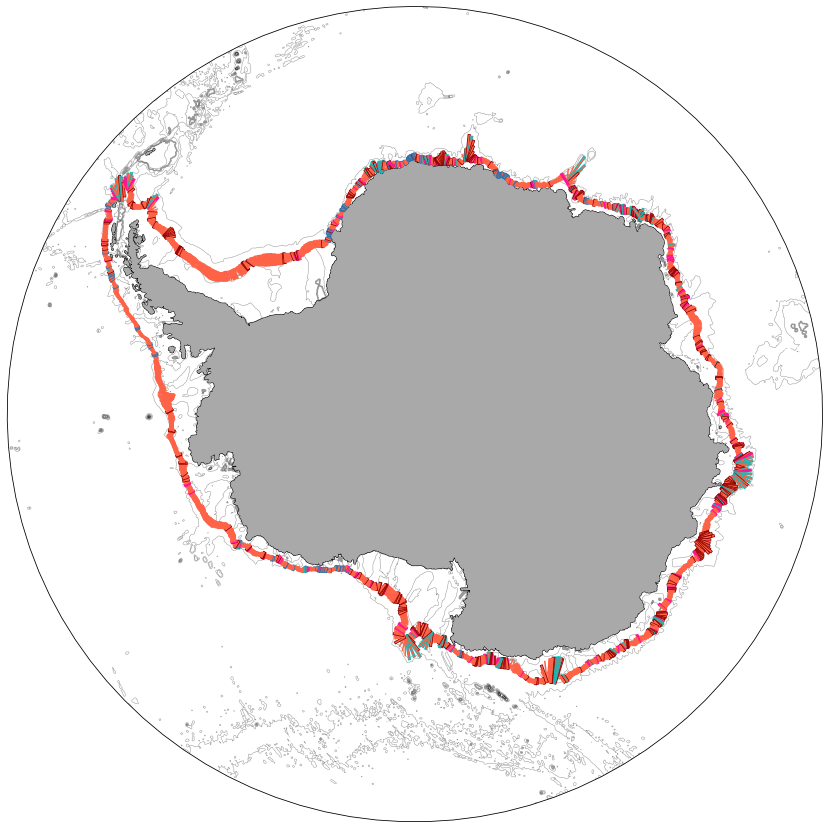

In [49]:
fig = plt.figure(1, figsize=(15,15))

for ff in range(1):
    ax0 = plt.subplot(1,1,ff+1, projection=ccrs.SouthPolarStereo())
    ax0.set_boundary(circle, transform=ax0.transAxes)

    # 1000 m isobath
    contour_1000m = hu.sel(yu_ocean = lat_slice)
    contour_1000m = contour_1000m.where(contour_1000m > 1000)
    contour_1000m = contour_1000m * 0 + 1
    contour_1000m = contour_1000m.fillna(0)
    
    # Plot land
    ax0.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
    ax0.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
    ax0.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5, transform = ccrs.PlateCarree())
    plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5, transform = ccrs.PlateCarree())

    # Plot transects
    for ii in range(len(lon_shelf)):
        if ii in (count_index_big):
            # Big bump transects
            plt.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='c', transform = ccrs.PlateCarree(), linewidth=3)
        if ii in (count_index_too_deep):
            # Transects with too deep first (shallowest) value
            plt.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', transform = ccrs.PlateCarree(), linewidth=3) 
        if ii in (count_index_small):
            # Small bump transects
            plt.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='darkred', transform = ccrs.PlateCarree(), linewidth=3)
        if ii in (index_skipped_head_tail):
            # Transects where we skip the head/tail because of a bump
            plt.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='deeppink', transform = ccrs.PlateCarree(), linewidth=3)
        else:
            # All transects
            plt.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato', transform = ccrs.PlateCarree())


Things to note:
- cyan transects: big bump transects that will be removed
- blue transects: transects with a shallowest value deeper than 1200 m, will be removed
- darkred transects: small bump transects that we keep, but in a modified form
- pink transects: skipped the head or tail because there was a bump
- orange transects: the rest

The big bumps occur in sections of the coastline where bigger spurs or troughs exist. It is okay to remove most of them as the coverage at the shelf contour is still high at the spurs. There is only one large trough that causes problems, but there are not too many transects that are problematic in this area anyway. 

### Example transects for the different cases

Define function to get bathymetry information.

In [50]:
# Pretty much the same code as above, but written as a function to call for specific transects that then can be plotted.

count = 0

max_depth = 2150#2010 # (st_ocean value deeper than target depth of 2000 m)
min_depth = 500#620  # (st_ocean value shallower than target depth of 650 m)
step_no   = 50   # Number of points on the transect that we interpolate the model grid onto

#for ii in range(len(lat_shelf)):
def get_hu_transects(value):
    # Looping through transect
    for ii in range(len(lat_shelf)):
        if ii == value:

            # 1 - Interpolate model grid bathymetry onto cross-slope transect, use method='nearest'
            hu_raw = cross_section(hu_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
            hu_raw = hu_raw.values
            hu_raw_orig = hu_raw.copy() # Making a copy to compare changes to original data
            # Also interpolate the velocity onto the cross-slope transects, use method='nearest'
            #u_raw = cross_section(u_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')

            # 2 - Skip head/tail
            # Set all values deeper than max_depth to the last value (skip tail)
            if np.any(hu_raw > max_depth) == True:
                index_max_depth = np.argwhere(hu_raw > max_depth)[0][0]
                hu_raw = hu_raw[:index_max_depth]
                #u_raw  = u_raw[:,:index_max_depth]
                # Write out for which transects we cut the tail
                #count_index_tail.append(ii)
            # Set all values shallower than min_depth to the next value (skip head)
            if np.any(hu_raw < min_depth) == True:
                index_min_depth = np.argwhere(hu_raw < min_depth)[-1][0]
                hu_raw = hu_raw[index_min_depth+1:]
                #u_raw  = u_raw[:,index_min_depth+1:]
                # Write out for which transects we cut the head
                #count_index_head.append(ii)

            if len(hu_raw) == 0:
                print('hu_raw was empty after skipping head/tail for index ', ii)
                #binned_product[ii,:,:] = np.nan
                #count_index_empty.append()
                continue

            # 3 - Ignore transects where the first value is too deep (some transects have nan at the beginning, get rid of the nans first)
            if np.isnan(hu_raw[0]) == True:
                #u_raw  = u_raw[:,~np.isnan(hu_raw)]
                hu_raw = hu_raw[~np.isnan(hu_raw)]
                index = ii
                if len(hu_raw) == 0:
                    #count_index_too_deep.append(ii)
                    #binned_product[ii,:,:] = np.nan
                    continue
            if (hu_raw[0] > 1200):
                #count_index_too_deep.append(ii)
                #binned_product[ii,:,:] = np.nan
                continue

            # 4 - Check the first time for monotonicity. If so, hu_raw is ready to be used for the depth binning process. 
            # The only thing we need to do is to get rid of duplicates.
            if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
                # Write out which transects didn't need any smoothing, flattening, etc...
                #count_index_ready.append(ii)
                # Get rid of any duplicates to make sure hu_raw is monotonically increasing:
                if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                    # Find that index
                    index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                    for ll in range(np.size(index_duplicate[0])):
                        index = index_duplicate[0][ll] + 1
                        var   = hu_raw[index]
                        hu_raw[index] = var + 0.001 * (ll+1)
                    del index_duplicate, index, var

            else:
                # 5 - Smoothing of small variability
                increment = 30 # in meter, smaller than the smallest change in the depth bins used later
                if np.any( np.abs(np.diff(hu_raw)) < increment) == True:
                    # Find that index
                    index_duplicate = np.where( np.abs(np.diff(hu_raw)) < increment)
                    for ll in range(np.size(index_duplicate[0])):
                        index = index_duplicate[0][ll] + 1
                        var = hu_raw[index-1]
                        hu_raw[index] = var
                    del index_duplicate, index, var

                # Again, make sure that no value is duplicated. This is to make it easier to select local minima and local maxima. 
                # This code differes slightly from the code above and below to change get rid of duplications, 
                # because here, we need hu_raw to increase and decrese depending on which side of a potentially existing bump we are.
                add_increment = get_increment_info(hu_raw)
                for ll in range(len(add_increment)):
                    var = hu_raw[ll]
                    if add_increment[ll] > 0:
                        hu_raw[ll] = var + (0.001*ll)
                    elif add_increment[ll] < 0:
                        hu_raw[ll] = var - (0.001*ll)
                del add_increment, var

                # Check if smoothing alone helped to achieve monotonicity   
                if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
                    # Write out which transects fall into this category
                    #count_index_smoothed.append(ii)
                    if np.all( np.sign(np.diff(hu_raw)) == 0) == True:
                        print('Index %i still has duplicates, this needs to be fixed!'%ii)

                else: 
                    # 6 - The remaining transects should have a bump (in other words, b and c below shouldn't be both empty)

                    # Sanity check for local minima and local maxima
                    b, c = get_local_min_max(hu_raw)
                    if (len(b)==0) and (len(c)==0):
                        print('Problem: b, c are zero for index ', ii)

                    # Skip the tail if the local maximum is deeper than the last value
                    if (len(c)>0):
                        index_tmp = np.argmax(hu_raw[c])
                        if hu_raw[c[index_tmp]] > hu_raw[-1]:
                            hu_raw = hu_raw[:c[index_tmp]+1]
                            #u_raw  = u_raw[:,:c[index_tmp]+1]
                            # Calculate local min/max again
                            b, c = get_local_min_max(hu_raw)
                        del index_tmp
                    # Skip the head if the local minimum is shallower than the first value
                    if (len(b)>0):
                        index_tmp = np.argmin(hu_raw[b])
                        if hu_raw[b[index_tmp]] < hu_raw[0]:
                            #print('entered loop')
                            hu_raw = hu_raw[b[index_tmp]:]
                            #u_raw  = u_raw[:,b[index_tmp]:]
                            b, c = get_local_min_max(hu_raw)
                        del index_tmp

                    # 7 - Now check for local minima and maxima
                    if (len(b) == 0) and (len(c) == 0):
                        # Might exist if we skipped tail/head
                        #index_skipped_head_tail.append(ii)
                        delta_h = None
                    elif (len(b) == 1) and (len(c) == 1):
                        # Only one bump exists
                        index_delta_h = 0
                        delta_h = hu_raw[c[index_delta_h]] - hu_raw[b[index_delta_h]]
                    elif (len(b) > 1) and (len(c) > 1):
                        # Multiple bumps exist, we are interested in the largest to classify the transect
                        index_length = np.min([len(b), len(c)])
                        delta_h = hu_raw[c[:index_length]] - hu_raw[b[:index_length]]
                        index_delta_h = np.argmax(delta_h)
                        delta_h = np.max(delta_h)
                        del index_length
                    elif (len(b)==1) and (len(c)!=1):
                        print('Only one minimum left, index ', ii)
                        delta_h = None
                    elif (len(b)!=1) and (len(c)==1):
                        print('Only one maximum left, index ', ii)
                        delta_h = None

                    # Classify into small or large bump transects
                    if delta_h != None:
                        # Only look at cases where we have bumps
                        if delta_h < 0:
                            # Sanity check for any negative delta_h. This would mean the local minimum and maximum used to calculate delta_h originates from different bumps
                            print('Negative delta for index ', ii)
                        elif delta_h > 200:
                            # 7.1 Big bumps
                            #binned_product[ii,:,:] = np.nan
                            #count_index_big.append(ii)
                            #delta_h_index_big.append(delta_h)
                            continue
                        elif (delta_h > 0) and (delta_h <= 200):
                            # 7.2 Small bumps
                            # Now, this is where the real joy begins...
                            #count_index_small.append(ii)
                            #delta_h_index_small.append(delta_h)
                            if hu_raw[c[index_delta_h]] == np.max(hu_raw):
                                # 7.2.1 Skip the tail if the local minimum is the deepest value. 
                                hu_raw = hu_raw[:c[index_delta_h]+1]
                                print('Case 5.3.1 for index ', ii)
                                del index_delta_h
                            else:
                                # 7.2.2 Flatten hu_raw for the remaining transects
                                # Find the depth of the first local maximum (a trough)
                                if len(b) != len(c):
                                    print('Number of minima and maxima not equal for index ', ii)
                                else:
                                    for mm in range(len(b)):
                                        hu_tmp = hu_raw[c[mm]]
                                        hu_tmp_next_index = np.argwhere(hu_raw[c[mm]:] > hu_tmp)[0][0]
                                        hu_raw[c[mm]:c[mm]+hu_tmp_next_index] = hu_raw[c[mm]]
                                        # Again, make sure bathymetry differs for each point
                                        if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                                            # Find that index
                                            index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                                            for ll in range(np.size(index_duplicate[0])):
                                                index = index_duplicate[0][ll] + 1
                                                var   = hu_raw[index]#.values
                                                hu_raw[index] = var + 0.001 * (ll+1)
                                            del index_duplicate, index, var

            # One last sanity check: hu_raw should (finally!) have a monotonic increase for all transects:
            if np.any(np.diff(hu_raw) < 0) == True:
                print('Last sanity check, problem with index ', ii) 
            # And if there are any duplicates
            if np.any(np.diff(hu_raw)) == 0:
                print('Last sanity check, problem with duplicates for index ', ii)
                   
    return hu_raw, hu_raw_orig


**Big bumps**

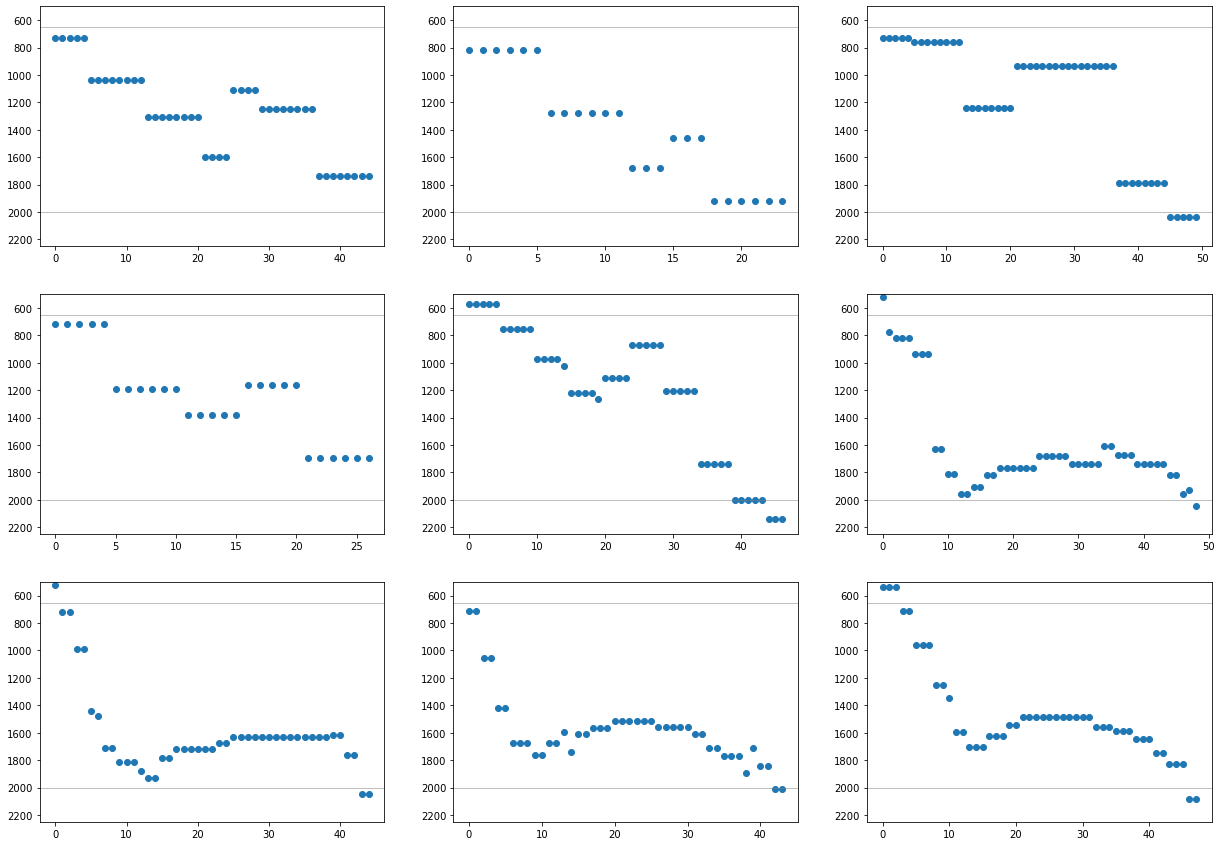

In [51]:
panel_count = 0
#fig = plt.figure(figsize=(21, 5 * int(len(count_index_big)/3)))
fig = plt.figure(figsize=(21, 5 * 3))

for ii in range(len(lat_shelf)):
    if ii in (count_index_big[:9]):
        hu_raw, hu_raw_orig = get_hu_transects(ii)
        panel_count += 1
        #plt.subplot(int(len(count_index_big)/3)+1, 3, (panel_count))
        plt.subplot(3, 3, (panel_count))
        plt.plot(hu_raw, 'o', color='C0')
        plt.ylim(2250, 500)
        plt.axhline( 650, color='0.5', linewidth=0.5)
        plt.axhline(2000, color='0.5', linewidth=0.5)

**Transects with skipped head / tail**

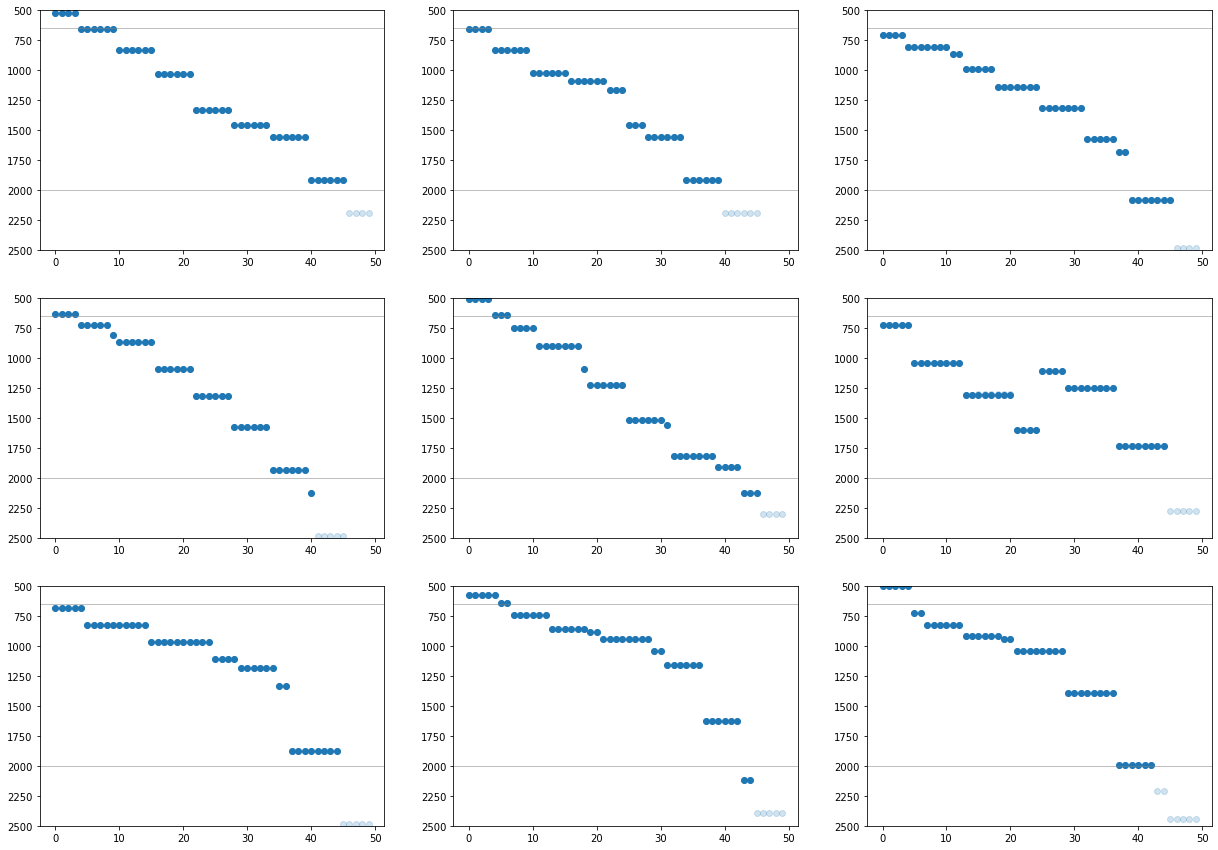

In [53]:
panel_count = 0
fig = plt.figure(figsize=(21, 5 * 3))

for ii in range(len(lat_shelf)):
    if ii in (count_index_tail[:9]):
        hu_raw, hu_raw_orig = get_hu_transects(ii)
        panel_count += 1
        plt.subplot(3, 3, (panel_count))
        plt.plot(hu_raw_orig, 'o', color='C0', alpha=0.2)
        #dd = len(hu_raw_orig) - len(hu_raw)
        #plt.plot(np.arange(0, len(hu_raw), 1)+dd, hu_raw, 'o', color='C0')
        plt.plot(hu_raw, 'o', color='C0')
        plt.ylim(2500, 500)
        plt.axhline( 650, color='0.5', linewidth=0.5)
        plt.axhline(2000, color='0.5', linewidth=0.5)

**Small bumps**

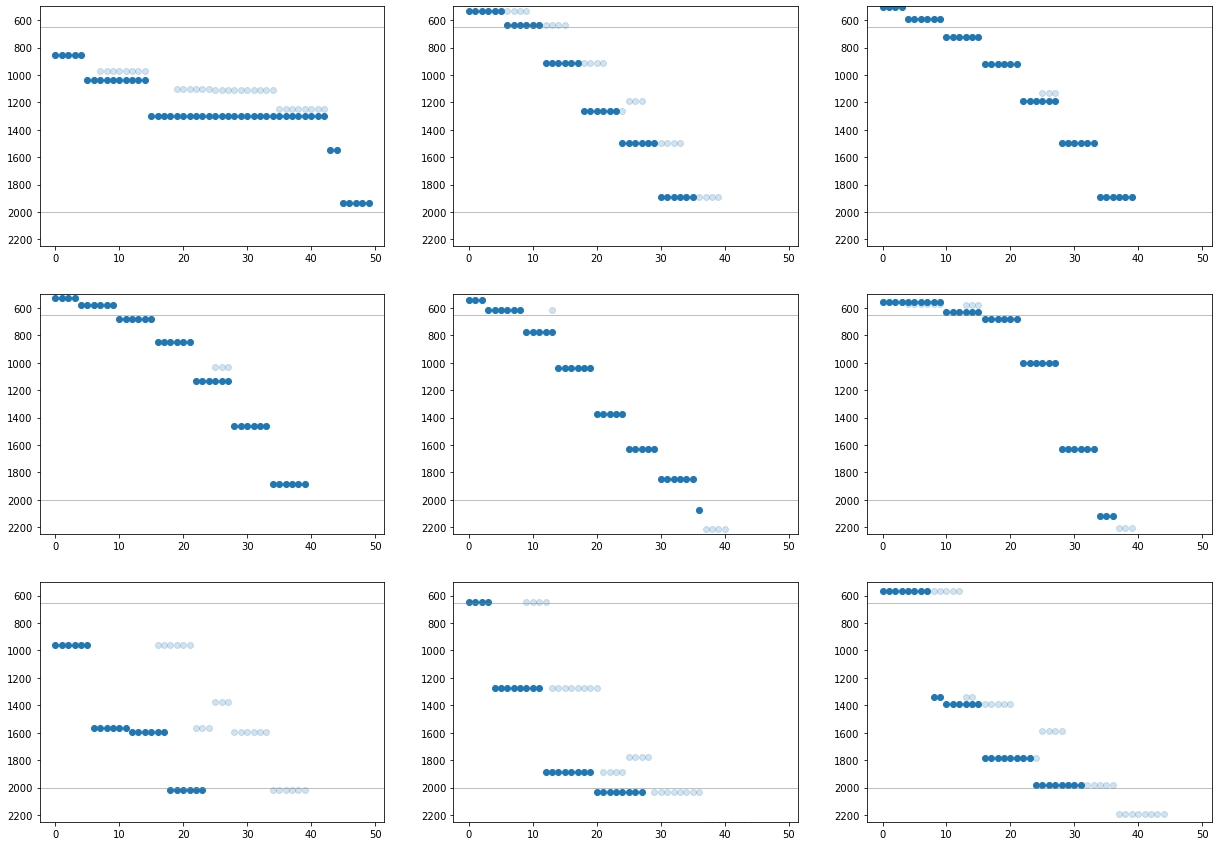

In [54]:
panel_count = 0
fig = plt.figure(figsize=(21, 5 * 3))

for ii in range(len(lat_shelf)):
    if ii in (count_index_small[:9]):
        hu_raw, hu_raw_orig = get_hu_transects(ii)
        panel_count += 1
        plt.subplot(3, 3, (panel_count))
        plt.plot(hu_raw_orig, 'o', color='C0', alpha=0.2)
        #dd = len(hu_raw_orig) - len(hu_raw)
        #plt.plot(np.arange(0, len(hu_raw), 1)+dd, hu_raw, 'o', color='C0')
        plt.plot(hu_raw, 'o', color='C0')
        plt.ylim(2250, 500)
        plt.axhline( 650, color='0.5', linewidth=0.5)
        plt.axhline(2000, color='0.5', linewidth=0.5)

**Transects with too deep first value**

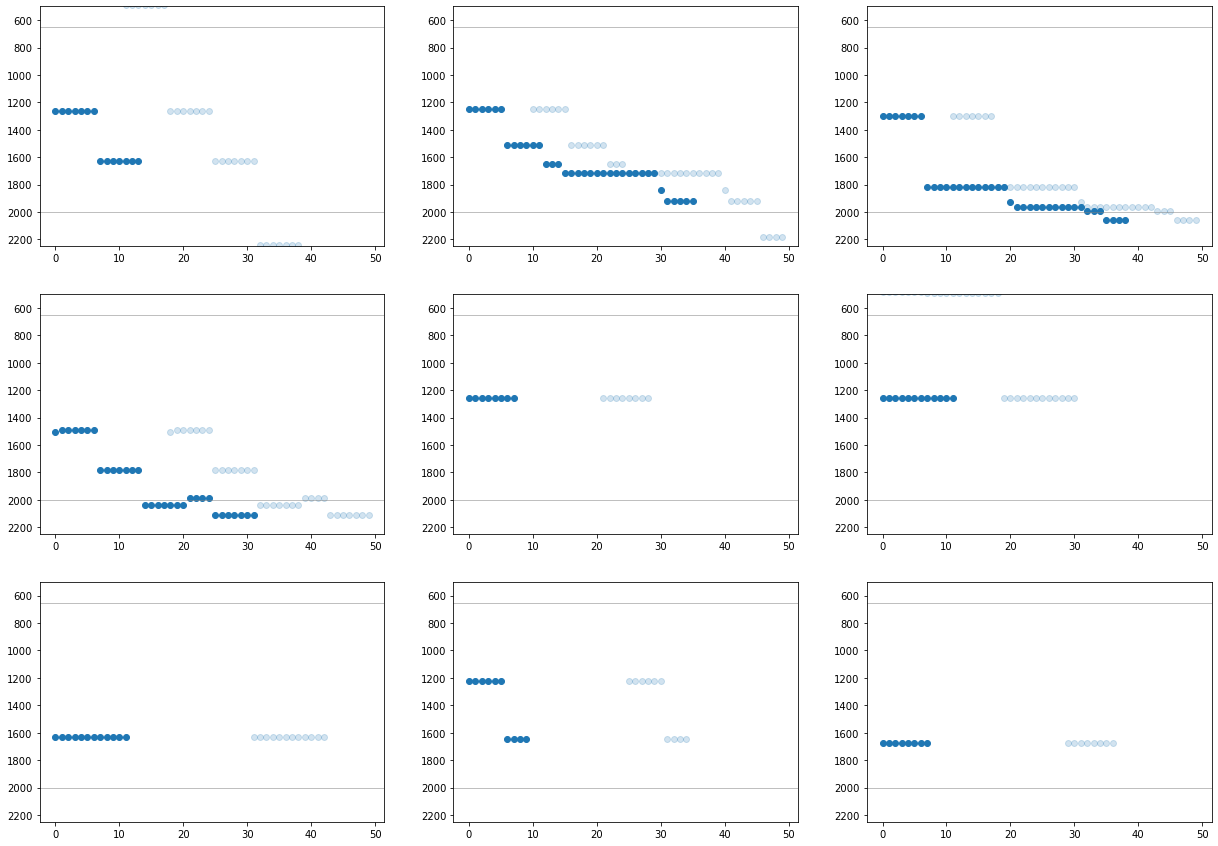

In [55]:
panel_count = 0
fig = plt.figure(figsize=(21, 5 * 3))

for ii in range(len(lat_shelf)):
    if ii in (count_index_too_deep[:9]):
        hu_raw, hu_raw_orig = get_hu_transects(ii)
        panel_count += 1
        plt.subplot(3, 3, (panel_count))
        plt.plot(hu_raw_orig, 'o', color='C0', alpha=0.2)
        plt.plot(hu_raw, 'o', color='C0')
        plt.ylim(2250, 500)
        plt.axhline( 650, color='0.5', linewidth=0.5)
        plt.axhline(2000, color='0.5', linewidth=0.5)

**Transects where smoothing made it monotonic**

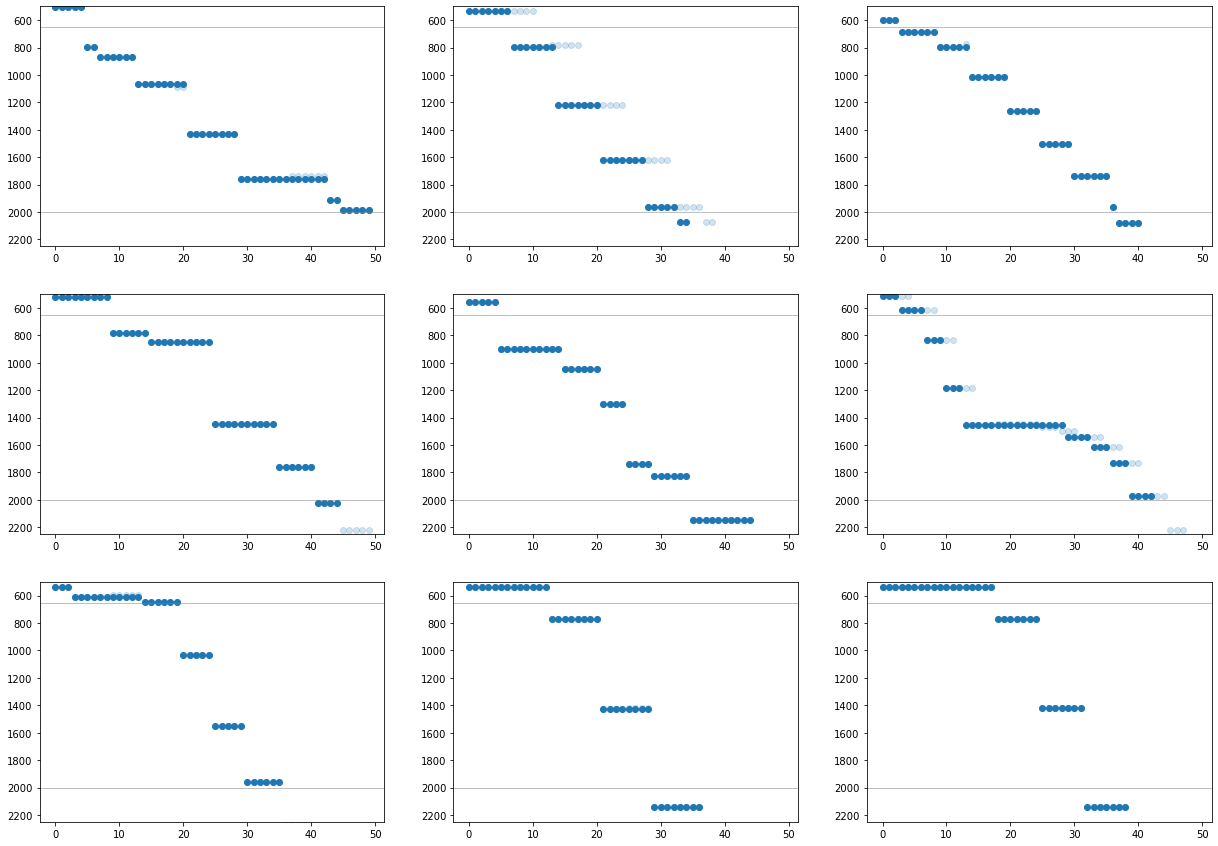

In [56]:
panel_count = 0
fig = plt.figure(figsize=(21, 5 * 3))

for ii in range(len(lat_shelf)):
    if ii in (count_index_smoothed[:9]):
        hu_raw, hu_raw_orig = get_hu_transects(ii)
        panel_count += 1
        plt.subplot(3, 3, (panel_count))
        plt.plot(hu_raw_orig, 'o', color='C0', alpha=0.2)
        plt.plot(hu_raw, 'o', color='C0')
        plt.ylim(2250, 500)
        plt.axhline( 650, color='0.5', linewidth=0.5)
        plt.axhline(2000, color='0.5', linewidth=0.5)

**Transects with skipped head/tail because of local minimum/maximum**

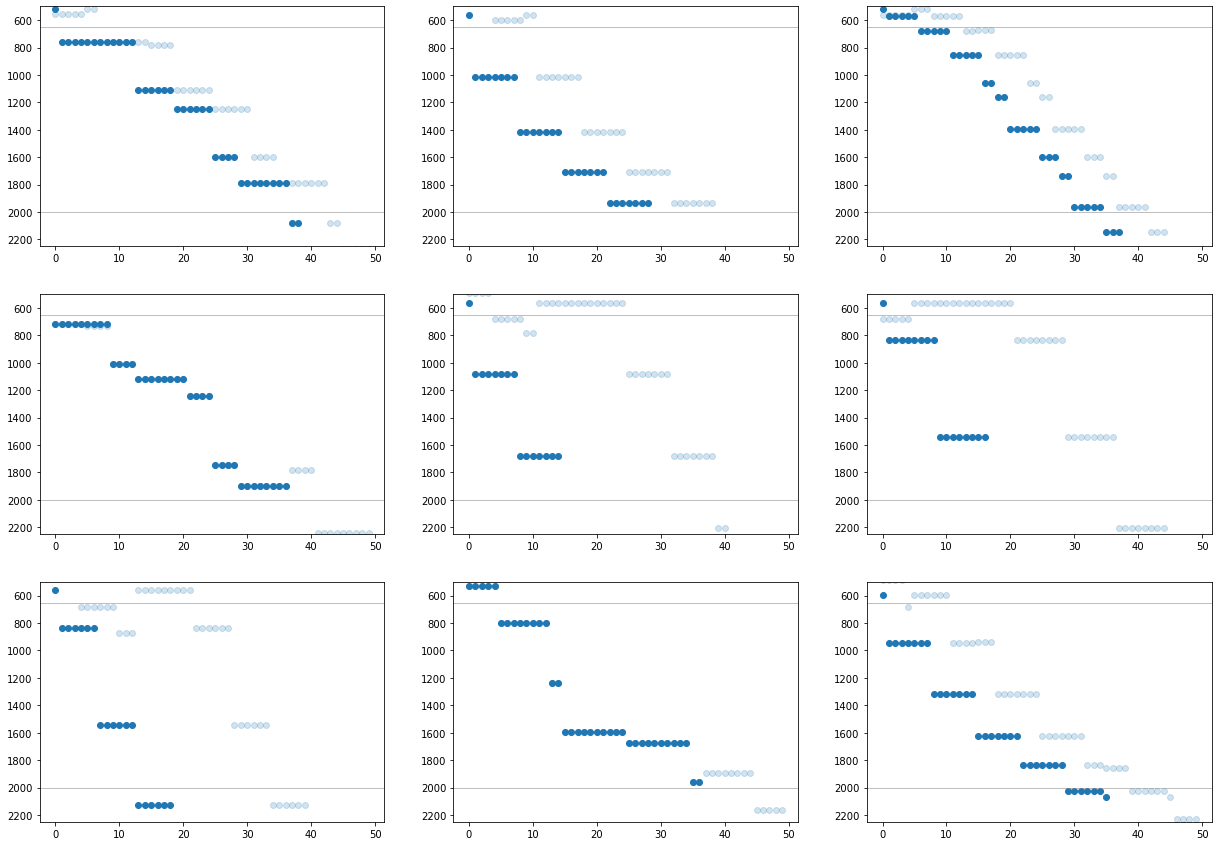

In [57]:
panel_count = 0
fig = plt.figure(figsize=(21, 5 * 3))

for ii in range(len(lat_shelf)):
    if ii in (index_skipped_head_tail[:9]):
        hu_raw, hu_raw_orig = get_hu_transects(ii)
        panel_count += 1
        plt.subplot(3, 3, (panel_count))
        plt.plot(hu_raw_orig, 'o', color='C0', alpha=0.2)
        plt.plot(hu_raw, 'o', color='C0')
        plt.ylim(2250, 500)
        plt.axhline( 650, color='0.5', linewidth=0.5)
        plt.axhline(2000, color='0.5', linewidth=0.5)

## 3 - Binning into depth space

### Testing criteria for binning

In [15]:
# Get depth bins (based on vertical model coordinate called st_ocean)
depth_avail = u_along.st_ocean.values
min_index   = np.argwhere(depth_avail > 600)[0][0]
max_index   = np.argwhere(depth_avail < 2200)[-1][0]
depth_bins_st_ocean = depth_avail[min_index:max_index]

In [16]:
# Double the resolution
np.diff(depth_bins_st_ocean)
depth_bins_double = []
for ii in range(len(depth_bins_st_ocean)-1):
    new = np.diff(depth_bins_st_ocean)[ii] / 2
    depth_bins_double.append(depth_bins_st_ocean[ii])
    depth_bins_double.append(depth_bins_st_ocean[ii]+new)
depth_bins_double.append(depth_bins_st_ocean[-1])

In [62]:
# A simplified version to test binning for some easy transects
def calc_binning(ii, depth_bins, method='linear'):
    step_no = 50
    max_depth = 2010 # (st_ocean value near 2000 m)
    min_depth = 620  # (st_ocean value near 650 m)
    
    # Interpolate model grid velocities onto cross-slope transect
    section_raw = cross_section(u_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
    hu_raw      = cross_section(hu_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
    
    # Get array with maximum water column depth from cross-slope transect's st_ocean
    depth_array = section_raw * 0 + section_raw.st_ocean
    depth_array = depth_array.max(dim='st_ocean', skipna=True)#[0,:]  # (skipping nans)
        
    # 3 - Make sure the depth info is monotonically increasing (not just equal or increasing)
    if np.any( np.diff(depth_array)**2 < 1e-4) == True:
        # Find index of 
        index_duplicate = np.where( np.diff(depth_array)**2 < 1e-4)
        for ll in range(np.size(index_duplicate[0])):
            index = index_duplicate[0][ll] + 1
            if not isinstance(depth_array, np.ndarray):
                # For some reason, depth_array is sometimes an dask array (e.g. ii=121)
                depth_array = depth_array.values
            var = depth_array[index]
            depth_array[index] = var + 0.0001 * (ll+1)
        
    # 4 - Interpolate to depth space (ignoring bumps at the moment)
    # Replace 'index' dimension by bathymetry value at that point 
    section_raw = section_raw.rename({'index': 'hu'})
    section_raw['hu'] = depth_array#.values
    # Interpolate to gridded bathymetry value
    section_binned = section_raw.interp(hu=depth_bins, kwargs={"fill_value": "extrapolate"}, method=method)
        
    return section_binned, section_raw, depth_array

Plot three  example transects

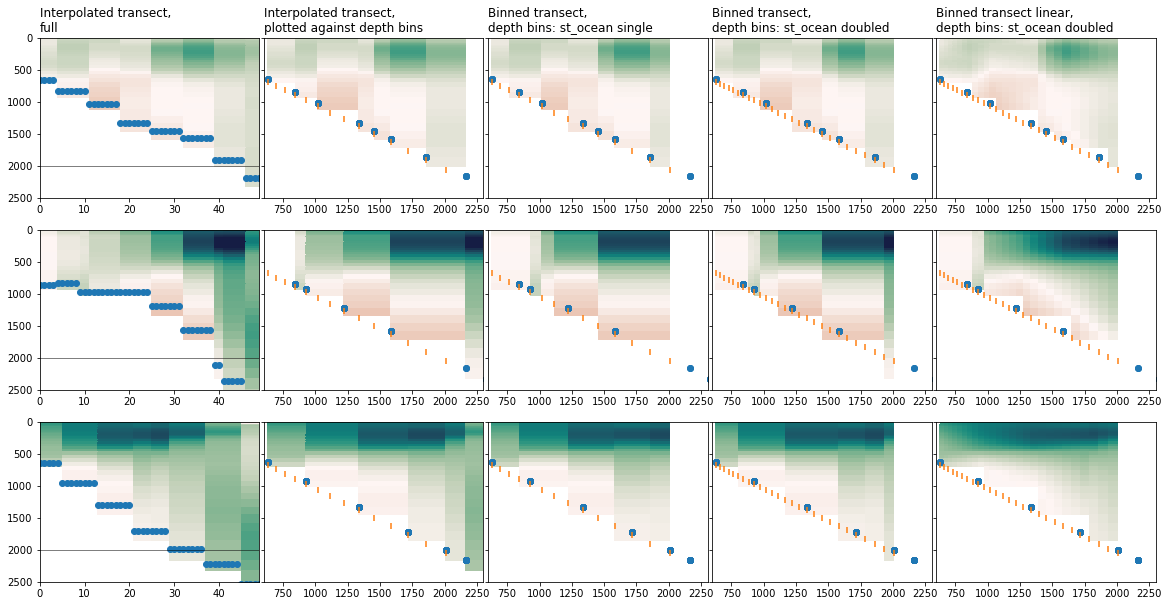

In [97]:
vmin_val = -0.2
vmax_val = 0.2

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20,10))

gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 0.05], hspace=0.2)#, wspace=1.5)

for ii in range(3):
    
    gs_tmp = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs[ii,:2], wspace=0.02)
    
    # Transect interpolation, plotted against num_points
    section_tmp, hu_tmp, depth_array_tmp = get_transect(ii*10, 'nearest')
    ax = fig.add_subplot(gs_tmp[0])
    if ii == 0:
        plt.title('Interpolated transect, \nfull', loc='left')
    sc = plt.pcolormesh(section_tmp.index, section_tmp.st_ocean, section_tmp, vmin=vmin_val, vmax=vmax_val, cmap=cm.cm.curl)
    plt.scatter(section_tmp.index, hu_tmp, color='C0')
    #plt.scatter(section_tmp.index, depth_array_tmp, color='C1')
    plt.ylim(2500, 0)
    plt.axhline(2000, color='k', linewidth=0.5)
    
    # Transect interpolation
    section_binned, section_raw, depth_array = calc_binning(ii*10, depth_bins_st_ocean, 'nearest')
    ax = fig.add_subplot(gs_tmp[1])
    ax.tick_params(labelleft=False)
    if ii == 0:
        plt.title('Interpolated transect, \nplotted against depth bins', loc='left')
    plt.pcolormesh(section_raw.hu, section_raw.st_ocean, section_raw, vmin=vmin_val, vmax=vmax_val, cmap=cm.cm.curl)
    plt.scatter(section_raw.hu, depth_array, color='C0')
    plt.scatter(section_binned.hu, depth_bins_st_ocean, color='C1', marker=3)
    plt.ylim(2500, 0)
    plt.xlim(600, 2300)
    
    # Binned transect, st_ocean as depth
    #section_binned, hu_tmp = calc_binning(ii*10, depth_bins_st_ocean, 'nearest')
    ax = fig.add_subplot(gs_tmp[2])
    ax.tick_params(labelleft=False)
    if ii == 0:
        plt.title('Binned transect, \ndepth bins: st_ocean single', loc='left')
    sc = plt.pcolormesh(section_binned.hu, section_binned.st_ocean, section_binned, vmin=vmin_val, vmax=vmax_val, cmap=cm.cm.curl)
    plt.scatter(section_raw.hu, depth_array, color='C0')
    plt.scatter(section_binned.hu, depth_bins_st_ocean, color='C1', marker=3)
    plt.ylim(2500, 0)
    plt.xlim(600, 2300)
    
    # Binned transect, double st_ocean as depth
    section_binned, section_raw, depth_array = calc_binning(ii*10, depth_bins_double, 'nearest')
    ax = fig.add_subplot(gs_tmp[3])
    ax.tick_params(labelleft=False)
    if ii == 0:
        plt.title('Binned transect, \ndepth bins: st_ocean doubled', loc='left')
    sc = plt.pcolormesh(section_binned.hu, section_binned.st_ocean, section_binned, vmin=vmin_val, vmax=vmax_val, cmap=cm.cm.curl)
    plt.scatter(section_raw.hu, depth_array, color='C0')
    plt.scatter(section_binned.hu, depth_bins_double, color='C1', marker=3)
    plt.ylim(2500, 0)
    plt.xlim(600, 2300)
    
    # Binned transect, double st_ocean as depth
    section_binned, section_raw, depth_array = calc_binning(ii*10, depth_bins_double, 'linear')
    ax = fig.add_subplot(gs_tmp[4])
    ax.tick_params(labelleft=False)
    if ii == 0:
        plt.title('Binned transect linear, \ndepth bins: st_ocean doubled', loc='left')
    sc = plt.pcolormesh(section_binned.hu, section_binned.st_ocean, section_binned, vmin=vmin_val, vmax=vmax_val, cmap=cm.cm.curl)
    plt.scatter(section_raw.hu, depth_array, color='C0')
    plt.scatter(section_binned.hu, depth_bins_double, color='C1', marker=3)
    plt.ylim(2500, 0)
    plt.xlim(600, 2300)
    
    

Things to note:
- Choice of depth bins: 
    - The orange ticks show the resolution of the depth bins. 
    - I test the depth values of st_ocean and double that (because of partial grid cells, we theoretically have a higher resolution that st_ocean available.
    - For the examples here, there doesn't seem to be a difference in the resolution that I get (compare column 3 and 4).
    - However, I can get more values at the deeper end of the transect. So this is an argument for using the **double st_ocean depth bins** (at least for the deep values).
- Choice of interpolation method:
    - The initial interpolation from the model grid to the transects is done using the 'nearest' method. (See discussion further above).
    - The interpolation for the depth binning is tested here, in columns 4 and 5.
    - The linear interpolation gives us a higher resolution, whereas the nearest value method gives us a better depth coverage (less nans near the sea floor).
    - We want the best of both worlds, so:
    - Use the linear interpolation for most cells, then fill up with the output from the nearest value method. See example below.

In [142]:
# Depth binning: replace nans in linear method with nearest value

def calc_binning_fill(ii, depth_bins, method='linear'):
    step_no = 50
    max_depth = 2010 # (st_ocean value near 2000 m)
    min_depth = 620  # (st_ocean value near 650 m)
    
    # Interpolate model grid velocities onto cross-slope transect
    section_raw = cross_section(u_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
    hu_raw      = cross_section(hu_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
    
    # Get array with maximum water column depth from cross-slope transect's st_ocean
    depth_array = section_raw * 0 + section_raw.st_ocean
    depth_array = depth_array.max(dim='st_ocean', skipna=True)#[0,:]  # (skipping nans)
    
    # 3 - Make sure the depth info is monotonically increasing (not just equal or increasing)
    if np.any( np.diff(depth_array)**2 < 1e-4) == True:
        # Find index of 
        index_duplicate = np.where( np.diff(depth_array)**2 < 1e-4)
        for ll in range(np.size(index_duplicate[0])):
            index = index_duplicate[0][ll] + 1
            if not isinstance(depth_array, np.ndarray):
                # For some reason, depth_array is sometimes an dask array (e.g. ii=121)
                depth_array = depth_array.values
            var = depth_array[index]
            depth_array[index] = var + 0.0001 * (ll+1)
        
    # 4 - Interpolate to depth space (ignoring bumps at the moment)
    # Replace 'index' dimension by bathymetry value at that point 
    section_raw = section_raw.rename({'index': 'hu'})
    section_raw['hu'] = depth_array#.values
    # Interpolate to gridded bathymetry value
    section_binned_linear = section_raw.interp(hu=depth_bins, kwargs={"fill_value": "extrapolate"}, method='linear')
    section_binned_nearest = section_raw.interp(hu=depth_bins, kwargs={"fill_value": "extrapolate"}, method='nearest')
    
    #section_binned_linear.where(np.isnan(section_binned_linear), section_binned_nearest)
    section_binned = section_binned_linear.where(np.isnan(section_binned_linear)==False, section_binned_nearest)
        
    return section_binned_linear, section_binned_nearest, section_binned

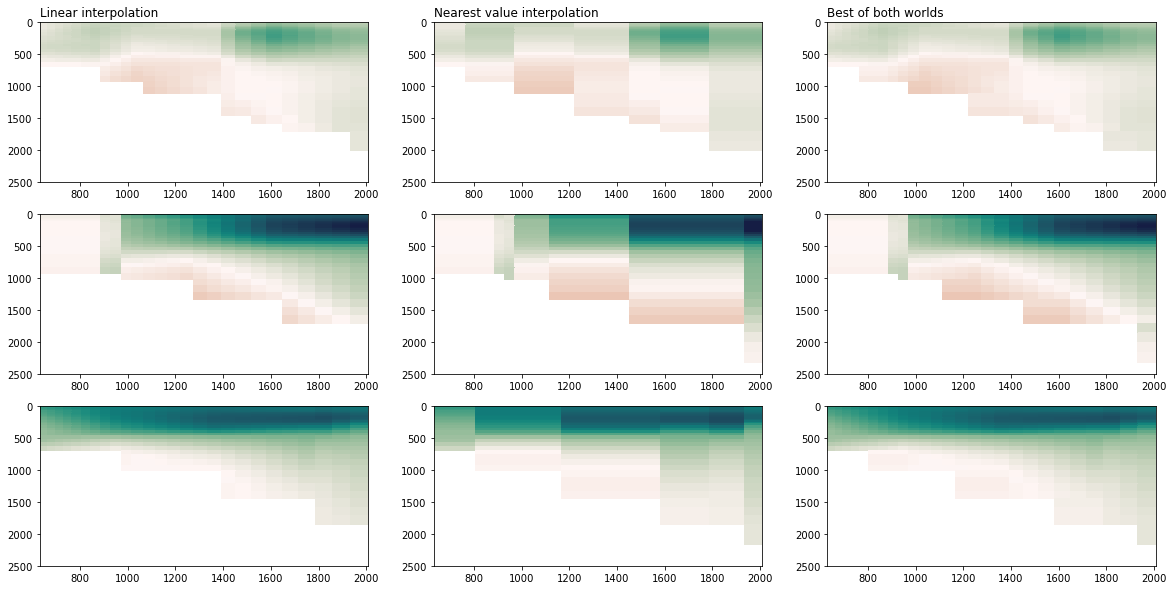

In [150]:
fig = plt.figure(figsize=(20,10))
xx = [1, 4, 7]

for ii in range(3):
    
    section_binned_linear, section_binned_nearest, section_binned = calc_binning_fill(ii*10, depth_bins_double, method='linear')
    
    plt.subplot(3,3,xx[ii])
    plt.pcolormesh(section_binned_linear.hu, section_binned_linear.st_ocean, section_binned_linear, vmin=-0.2, vmax=0.2, cmap=cm.cm.curl)
    plt.ylim(2500, 0)
    if ii == 0:
        plt.title('Linear interpolation', loc='left')

    plt.subplot(3,3,xx[ii]+1)
    plt.pcolormesh(section_binned_nearest.hu, section_binned_nearest.st_ocean, section_binned_nearest, vmin=-0.2, vmax=0.2, cmap=cm.cm.curl)
    plt.ylim(2500, 0)
    if ii == 0:
        plt.title('Nearest value interpolation', loc='left')

    plt.subplot(3,3,xx[ii]+2)
    plt.pcolormesh(section_binned.hu, section_binned.st_ocean, section_binned, vmin=-0.2, vmax=0.2, cmap=cm.cm.curl)
    plt.ylim(2500, 0)
    if ii == 0:
        plt.title('Best of both worlds', loc='left'); # Combined

### Binning of the interpolated transects to depth space

Use the 'master' code from the beginning for the bathymetry. This time, add the velocity and binning into depth space at the end. Write everything out into one dataset with the dimensions depth levels, number of transects, number of depth bins.

In [17]:
# 2d array with depth information, used later to set values deeper than depth bin to nan
depth_avail_2d = np.ones((len(depth_avail), len(depth_bins_double))) * np.nan
for ii in range(len(depth_bins_double)):
    depth_avail_tmp = np.where(depth_avail < depth_bins_double[ii], depth_avail, np.nan)
    depth_avail_2d[:,ii] = depth_avail_tmp    

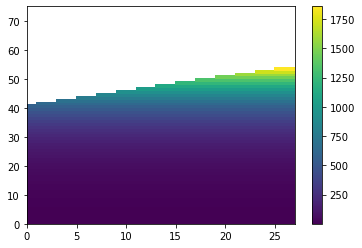

In [59]:
fig = plt.figure()
plt.pcolormesh(depth_avail_2d)
plt.colorbar()

**This is where the binning for the velocity field is actually done:**

Do it in segments going along the coastline as the code takes a long time to run. We combine the datasets later.

In [19]:
#%%time
#count = 0
# Define various variables used below when looping through each transect.

max_depth = 2150#2010 # (st_ocean value deeper than target depth of 2000 m)
min_depth = 500#620  # (st_ocean value shallower than target depth of 650 m)
step_no   = 50   # Number of points on the transect that we interpolate the model grid onto

binned_product = np.ones((len(lat_shelf), 12, len(depth_avail), len(depth_bins_double))) * np.nan# 1e6
ii_val = []
for ii in range(len(lat_shelf)):
    # Looping through each transect
    #if (ii > 2600) and (ii <= 3000):
    #if ii == count_index_small[30]:
    if ii >= 3000:#) and (ii< 4000):
        ii_val.append(ii)
        if not ii % 20:
            print('index:', ii)
        # 1 - Interpolate model grid bathymetry onto cross-slope transect, use method='nearest'
        hu_raw = cross_section(hu_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
        hu_raw = hu_raw.values
        hu_raw_orig = hu_raw.copy() # Making a copy to compare change to original data
        # Also interpolate the velocity onto the cross-slope transects, use method='nearest'
        u_raw = cross_section(u_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')

        # 2 - Skip head/tail
        # Set all values deeper than max_depth to the last value (skip tail)
        if np.any(hu_raw > max_depth) == True:
            index_max_depth = np.argwhere(hu_raw > max_depth)[0][0]
            hu_raw = hu_raw[:index_max_depth]
            u_raw  = u_raw[:,:,:index_max_depth]
        # Set all values shallower than min_depth to the next value (skip head)
        if np.any(hu_raw < min_depth) == True:
            index_min_depth = np.argwhere(hu_raw < min_depth)[-1][0]
            hu_raw = hu_raw[index_min_depth+1:]
            u_raw  = u_raw[:,:,index_min_depth+1:]

        if len(hu_raw) == 0:
            print('hu_raw was empty after skipping head/tail for index ', ii)
            binned_product[ii,:,:,:] = np.nan
            continue
            
        # 3 - Ignore transects where the first value is too deep (some transects have nan at the beginning, get rid of the nans first)
        if np.isnan(hu_raw[0]) == True:
            u_raw  = u_raw[:,:,~np.isnan(hu_raw)]
            hu_raw = hu_raw[~np.isnan(hu_raw)]
            if len(hu_raw) == 0:
                #count_index_too_deep.append(ii)
                binned_product[ii,:,:,:] = np.nan
                continue
        if (hu_raw[0] > 1200):
            #count_index_too_deep.append(ii)
            binned_product[ii,:,:,:] = np.nan
            continue
        
        # 4 - Check the first time for monotonicity. If so, hu_raw is ready to be used for the depth binning process. 
        # The only thing we need to do is to get rid of duplicates.
        if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
            # Write out which transects didn't need any smoothing, flattening, etc...
            #count_index_ready.append(ii)
            # Get rid of any duplicates to make sure hu_raw is monotonically increasing:
            if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                # Find that index
                index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                for ll in range(np.size(index_duplicate[0])):
                    index = index_duplicate[0][ll] + 1
                    var   = hu_raw[index]
                    hu_raw[index] = var + 0.001 * (ll+1)
                del index_duplicate, index, var

        else:
            # 5 - Smoothing of small variability
            increment = 30 # in meter, smaller than the smallest change in the depth bins used later
            if np.any( np.abs(np.diff(hu_raw)) < increment) == True:
                # Find that index
                index_duplicate = np.where( np.abs(np.diff(hu_raw)) < increment)
                for ll in range(np.size(index_duplicate[0])):
                    index = index_duplicate[0][ll] + 1
                    var = hu_raw[index-1]
                    hu_raw[index] = var
                del index_duplicate, index, var

            # Again, make sure that no value is duplicated. This is to make it easier to select local minima and local maxima. 
            # This code differes slightly from the code above and below to change get rid of duplications, 
            # because here, we need hu_raw to increase and decrese depending on which side of a potentially existing bump we are.
            add_increment = get_increment_info(hu_raw)
            for ll in range(len(add_increment)):
                var = hu_raw[ll]
                if add_increment[ll] > 0:
                    hu_raw[ll] = var + (0.001*ll)
                elif add_increment[ll] < 0:
                    hu_raw[ll] = var - (0.001*ll)
            del add_increment, var
            
            # Check if smoothing alone helped to achieve monotonicity   
            if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
                if np.all( np.sign(np.diff(hu_raw)) == 0) == True:
                    print('Index %i still has duplicates, this needs to be fixed!'%ii)
               
            else: 
                # 6 - The remaining transects should have a bump (in other words, b and c below shouldn't be both empty)
            
                # Sanity check for local minima and local maxima
                b, c = get_local_min_max(hu_raw)
                if (len(b)==0) and (len(c)==0):
                    print('Problem: b, c are zero for index ', ii)
                
                # Skip the tail if the local maximum is deeper than the last value
                if (len(c)>0):
                    index_tmp = np.argmax(hu_raw[c])
                    if hu_raw[c[index_tmp]] > hu_raw[-1]:
                        hu_raw = hu_raw[:c[index_tmp]+1]
                        u_raw  = u_raw[:,:,:c[index_tmp]+1]
                        # Calculate local min/max again
                        b, c = get_local_min_max(hu_raw)
                    del index_tmp
                # Skip the head if the local minimum is shallower than the first value
                if (len(b)>0):
                    index_tmp = np.argmin(hu_raw[b])
                    if hu_raw[b[index_tmp]] < hu_raw[0]:
                        #print('entered loop')
                        hu_raw = hu_raw[b[index_tmp]:]
                        u_raw  = u_raw[:,:,b[index_tmp]:]
                        b, c = get_local_min_max(hu_raw)
                    del index_tmp
                    
                # 7 - Now check for local minima and maxima
                if (len(b) == 0) and (len(c) == 0):
                    # Might exist if we skipped tail/head
                    delta_h = None
                elif (len(b) == 1) and (len(c) == 1):
                    # Only one bump exists
                    index_delta_h = 0
                    delta_h = hu_raw[c[index_delta_h]] - hu_raw[b[index_delta_h]]
                elif (len(b) > 1) and (len(c) > 1):
                    # Multiple bumps exist, we are interested in the largest to classify the transect
                    index_length = np.min([len(b), len(c)])
                    delta_h = hu_raw[c[:index_length]] - hu_raw[b[:index_length]]
                    index_delta_h = np.argmax(delta_h)
                    delta_h = np.max(delta_h)
                    del index_length
                elif (len(b)==1) and (len(c)!=1):
                    print('Only one minimum left, index ', ii)
                    delta_h = None
                elif (len(b)!=1) and (len(c)==1):
                    print('Only one maximum left, index ', ii)
                    delta_h = None

                # Classify into small or large bump transects
                if delta_h != None:
                    # Only look at cases where we have bumps
                    if delta_h < 0:
                        # Sanity check for any negative delta_h. This would mean the local minimum and maximum used to calculate delta_h originates from different bumps
                        print('Negative delta for index ', ii)
                    elif delta_h > 200:
                        # 7.1 Big bumps
                        binned_product[ii,:,:,:] = np.nan
                        continue
                    elif (delta_h > 0) and (delta_h <= 200):
                        # 7.2 Small bumps
                        # Now, this is where the real joy begins...
                        #count_index_small.append(ii)
                        #delta_h_index_small.append(delta_h)
                        if hu_raw[c[index_delta_h]] == np.max(hu_raw):
                            # 7.2.1 Skip the tail if the local minimum is the deepest value. 
                            hu_raw = hu_raw[:c[index_delta_h]+1]
                            print('Case 5.3.1 for index ', ii)
                            del index_delta_h
                        else:
                            # 7.2.2 Flatten hu_raw for the remaining transects
                            # Find the depth of the first local maximum (a trough)
                            if len(b) != len(c):
                                print('Number of minima and maxima not equal for index ', ii)
                            else:
                                for mm in range(len(b)):
                                    hu_tmp = hu_raw[c[mm]]
                                    hu_tmp_next_index = np.argwhere(hu_raw[c[mm]:] > hu_tmp)[0][0]
                                    hu_raw[c[mm]:c[mm]+hu_tmp_next_index] = hu_raw[c[mm]]
                                    # Again, make sure bathymetry differs for each point
                                    if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                                        # Find that index
                                        index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                                        for ll in range(np.size(index_duplicate[0])):
                                            index = index_duplicate[0][ll] + 1
                                            var   = hu_raw[index]#.values
                                            hu_raw[index] = var + 0.001 * (ll+1)
                                        del index_duplicate, index, var

        # One last sanity check: hu_raw should (finally!) have a monotonic increase for all transects:
        if np.any(np.diff(hu_raw) < 0) == True:
            print('Last sanity check, problem with index ', ii) 
        # And if there are any duplicates
        if np.any(np.diff(hu_raw)) == 0:
            print('Last sanity check, problem with duplicates for index ', ii)

        # Now, let's do the binning to depth space for the remaining transects
        # Replace 'index' dimension by bathymetry value at that point 
        u_raw = u_raw.rename({'index': 'hu'})
        u_raw['hu'] = hu_raw
        # Interpolate to gridded bathymetry value
        section_binned_linear  = u_raw.interp(hu=depth_bins_double, kwargs={"fill_value": "extrapolate"}, method='linear')
        section_binned_nearest = u_raw.interp(hu=depth_bins_double, kwargs={"fill_value": "extrapolate"}, method='nearest')
        # Replace nans near the bottom with nearest value
        section_binned = section_binned_linear.where(np.isnan(section_binned_linear)==False, section_binned_nearest)
        # Set values deeper than depth_bins_double to nan (due to the nearest method we sometimes get values deeper than the desired bin)
        section_binned = section_binned.where(np.isnan(depth_avail_2d)== False, np.nan)
        # Finished
        binned_product[ii,:,:,:] = section_binned.values

save_dir = '/g/data/x77/wgh581/Post_Process/'
#outfile = 'binned_product_monthly.npz'
outfile = 'binned_product_monthly_3000_end.npz'
np.savez(save_dir + outfile, binned_product=binned_product)
print('Done.')

index: 3000
index: 3020
index: 3040
index: 3060
index: 3080
index: 3100
index: 3120
index: 3140
index: 3160
index: 3180
index: 3200
index: 3220
index: 3240
index: 3260
index: 3280
index: 3300
index: 3320
index: 3340
index: 3360
index: 3380
index: 3400
index: 3420
index: 3440
index: 3460
index: 3480
index: 3500
Done.


I ran the script here step by step. The following combines the outputted data and saves them as nc file. 

**Monthly data**

In [26]:
data  = np.load(save_dir + 'binned_product_monthly_0_470.npz')
data1 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_470_1000.npz')
data2 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_1000_2000.npz')
data3 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_2000_2500.npz')
data4 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_2500_3000.npz')
data5 = data['binned_product']
data  = np.load(save_dir + 'binned_product_monthly_3000_end.npz')
data6 = data['binned_product']

In [38]:
binned_product_monthly = data1
binned_product_monthly[470:1000,:,:,:]  = data2[470:1000,:,:,:]
binned_product_monthly[1000:2000,:,:,:] = data3[1000:2000,:,:,:]
binned_product_monthly[2000:2500,:,:,:] = data4[2000:2500,:,:,:]
binned_product_monthly[2500:3000,:,:,:] = data5[2500:3000,:,:,:]
binned_product_monthly[3000:,:,:,:]     = data6[3000:,:,:,:]

**Daily data**

Function to load in data

In [61]:
file_name = 'transects_binned_daily_test.nc'
def import_data(file_name):
    # Import as DataArray
    ds = xr.open_dataarray(file_path + file_name)
    # Select depth slice of interest
    ds = ds.sel(st_ocean = st_ocean_slice)
    
    return ds

In [62]:
ds = import_data(file_name)

In [60]:
ds

<xarray.DataArray (lon_shelf: 3520, time: 365, st_ocean: 54, depth_bin: 27)>
[1873238400 values with dtype=float64]
Coordinates:
  * time       (time) object 2086-01-01 12:00:00 ... 2086-12-31 12:00:00
  * lon_shelf  (lon_shelf) float64 -279.9 -279.8 -279.6 ... 79.7 79.8 79.9
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 1.716e+03 1.858e+03
  * depth_bin  (depth_bin) float64 630.7 663.1 695.4 ... 1.933e+03 2.007e+03
Attributes:
    description:  along-slope velocity
    units:        m/s

Now, load in more files and combine them

In [80]:
# Transects 10 to 100:
file_name = 'transects_binned_daily_10_100.nc'
tmp = import_data(file_name)
ds[11:101,:,:,:] = tmp[11:101,:,:,:]

In [81]:
# Transects 100 to 200:
file_name = 'transects_binned_daily_100_200.nc'
tmp = import_data(file_name)
ds[101:201,:,:,:] = tmp[101:201,:,:,:]

In [82]:
# Transects 200 to 500:
file_name = 'transects_binned_daily_200_500.nc'
tmp = import_data(file_name)
ds[201:501,:,:,:] = tmp[201:501,:,:,:]

In [83]:
# Transects 500 to 1000:
file_name = 'transects_binned_daily_500_1000.nc'
tmp = import_data(file_name)
ds[501:1001,:,:,:] = tmp[501:1001,:,:,:]

In [ ]:
# Transects 1000 to 1100:
file_name = 'transects_binned_daily_1000_1100.nc'
tmp = import_data(file_name)
ds[1001:1101,:,:,:] = tmp[1001:1101,:,:,:]

In [ ]:
# Transects 1100 to 1500:
file_name = 'transects_binned_daily_1100_1500.nc'
tmp = import_data(file_name)
ds[1101:1501,:,:,:] = tmp[1101:1501,:,:,:]

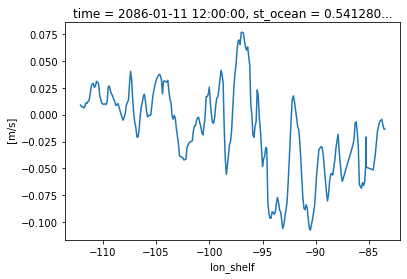

In [109]:
# Transects 1500 to 1750:
file_name = 'transects_binned_daily_1500_1750.nc'
tmp = import_data(file_name)
ds[1501:1751,:,:,:] = tmp[1501:1751,:,:,:]
tmp[1501:1751,10,0,10].plot()

In [ ]:
# Transects 1750 to 2000:
file_name = 'transects_binned_daily_1750_2000.nc'
tmp = import_data(file_name)
ds[1751:2001,:,:,:] = tmp[1751:2001,:,:,:]

In [ ]:
# Transects 2000 to 2250:
file_name = 'transects_binned_daily_2000_2250.nc'
tmp = import_data(file_name)
ds[2001:2251,:,:,:] = tmp[2001:2251,:,:,:]

In [ ]:
# Transects 2250 to 2500:
file_name = 'transects_binned_daily_2250_2500.nc'
tmp = import_data(file_name)
ds[2251:2501,:,:,:] = tmp[2251:2501,:,:,:]

In [ ]:
# Transects 2500 to 2750:
file_name = 'transects_binned_daily_2500_2750.nc'
tmp = import_data(file_name)
ds[2501:2751,:,:,:] = tmp[2501:2751,:,:,:]

In [ ]:
# Transects 2750 to 3000:
file_name = 'transects_binned_daily_2750_3000.nc'
tmp = import_data(file_name)
ds[2751:3001,:,:,:] = tmp[2751:3001,:,:,:]

In [ ]:
# Transects 3000 to 3250:
file_name = 'transects_binned_daily_3000_3250.nc'
tmp = import_data(file_name)
ds[3001:3251,:,:,:] = tmp[3001:3251,:,:,:]

In [ ]:
# Transects 3250 to 3500:
file_name = 'transects_binned_daily_3250_3500.nc'
tmp = import_data(file_name)
ds[3251:3501,:,:,:] = tmp[3251:3501,:,:,:]

In [97]:
# Transects 3500 to end:
file_name = 'transects_binned_daily_3500_end.nc'
tmp = import_data(file_name)
ds[3500:,:,:,:] = tmp[3500:,:,:,:]

Check if ds has now the full information

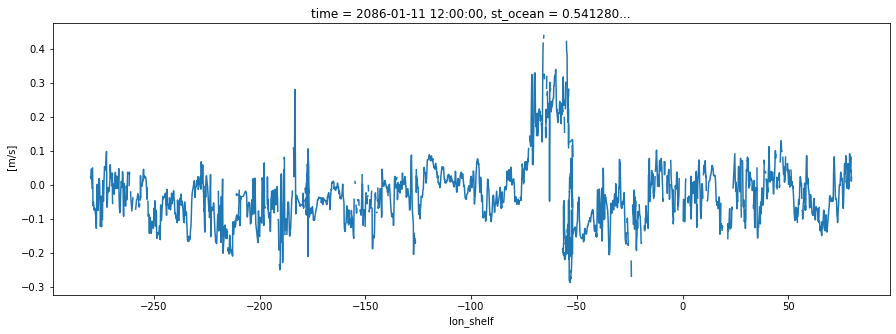

In [114]:
fig = plt.figure(figsize=(15,5))
ds[:,10,0,10].plot()

In [116]:
# Write dataset
ds.to_netcdf(file_path + 'transects_binned_daily_full.nc')

In [117]:
# Load in saved data to test if it's all there
ds_loaded = xr.open_dataarray(file_path + 'transects_binned_daily_full.nc')

In [118]:
ds_loaded

<xarray.DataArray (lon_shelf: 3520, time: 365, st_ocean: 54, depth_bin: 27)>
[1873238400 values with dtype=float64]
Coordinates:
  * time       (time) object 2086-01-01 12:00:00 ... 2086-12-31 12:00:00
  * lon_shelf  (lon_shelf) float64 -279.9 -279.8 -279.6 ... 79.7 79.8 79.9
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 1.716e+03 1.858e+03
  * depth_bin  (depth_bin) float64 630.7 663.1 695.4 ... 1.933e+03 2.007e+03
Attributes:
    description:  along-slope velocity
    units:        m/s

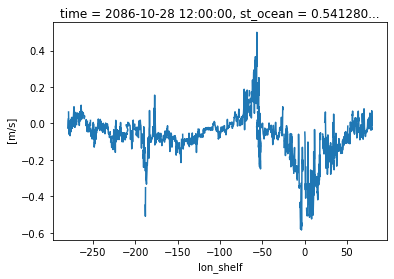

In [120]:
ds_loaded[:,300,0,10].plot()

---

---

(2500.0, 0.0)

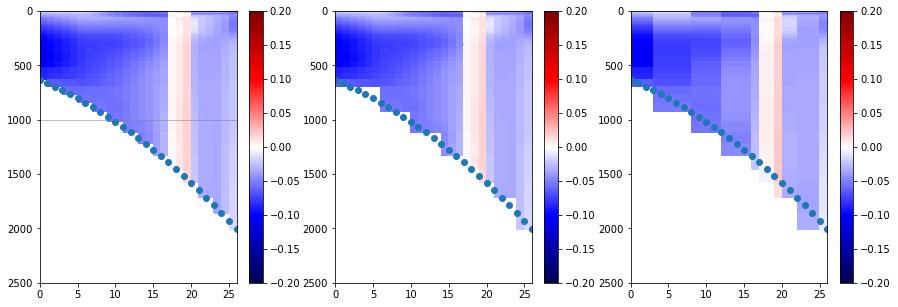

In [135]:
# Testing of interpolated transects

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.pcolormesh(np.arange(0, len(depth_bins_double), 1), depth_avail, binned_product[count_index_small[30],:,:], vmin=-0.2, vmax=0.2, cmap='seismic') 
plt.colorbar()
plt.scatter(np.arange(0, len(depth_bins_double), 1), depth_bins_double)
plt.ylim(2500, 0)
plt.axhline(1000, color='0.5', linewidth=0.5)

plt.subplot(1, 3, 2)
plt.pcolormesh(np.arange(0, len(depth_bins_double), 1), depth_avail, section_binned_linear, vmin=-0.2, vmax=0.2, cmap='seismic') 
plt.colorbar()
plt.scatter(np.arange(0, len(depth_bins_double), 1), depth_bins_double)
plt.ylim(2500, 0)

plt.subplot(1, 3, 3)
plt.pcolormesh(np.arange(0, len(depth_bins_double), 1), depth_avail, section_binned_nearest, vmin=-0.2, vmax=0.2, cmap='seismic') 
plt.colorbar()
plt.scatter(np.arange(0, len(depth_bins_double), 1), depth_bins_double)
plt.ylim(2500, 0)


Figure above compares different interpolation methods
- Left: combned as used for the final product
- Middle: linear interpolation
- Right: nearest value

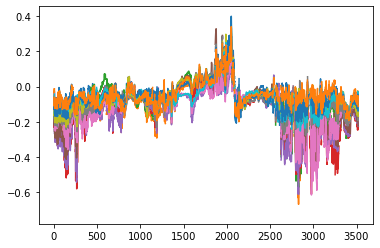

In [39]:
plt.figure()
for ll in range(12):
    plt.plot(binned_product_monthly[:,ll,0,10])

In [53]:
# Write as DataArray
ds = xr.DataArray(data=binned_product_monthly, dims=['lon_shelf', 'month', 'st_ocean', 'depth_bin'], attrs=dict(description='along-slope velocity', units='m/s'))
ds['lon_shelf'] = lon_shelf
ds['month']     = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds['st_ocean']  = depth_avail
ds['depth_bin'] = depth_bins_double
# Saving
ds.to_netcdf(save_dir + 'binned_product_monthly.nc')

(50.0, 0.0)

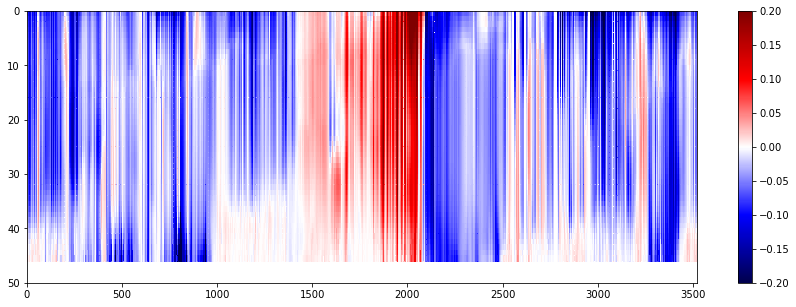

In [47]:
fig = plt.figure(figsize=(15, 5))
plt.pcolormesh(ds[:,0,:,10].transpose(), vmin=-0.2, vmax=0.2, cmap='seismic')
plt.colorbar()
plt.ylim(50, 0)